In [1]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_ident = "bidiretional_lstm"
unique_iden = "epoch100_emb128"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [4]:
config = {
    "n_epochs":100,
    "model":{
        "seq_len":50,
        "input_size":36,
        "hidden_size":512,
        "linear_filters":[128,256,512],
        "embedding_size":128,
        "num_layers":1,
        "bidirectional":True,
        "batch_size":32,
        "dev":device
    }
}

In [5]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [8]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [9]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6746, 1446, 1445)

In [10]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [11]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6720, 1440, 1440)

In [12]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],file_name=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split(os.path.sep)[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [13]:
train_data = SkeletonDataset(train_file_list,clsname2id)
val_data = SkeletonDataset(val_file_list,clsname2id)
test_data = SkeletonDataset(test_file_list,clsname2id)

In [14]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [16]:
for i in train_dl:
    print(i[0].shape)
    break

torch.Size([32, 50, 36])


In [298]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,batch_size=32,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32,dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32,dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [299]:
encoder = BiLSTMEncoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    batch_size=config["model"]["batch_size"],
    dev=config["model"]["dev"]).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    batch_size=config["model"]["batch_size"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    batch_size=config["model"]["batch_size"],
    dev=config["model"]["dev"])

In [300]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=36, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (out_linear): Linear(in_features=2048, out_features=128, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=128, out_features=2048, bias=True)
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=36, bias=True)
    )
  )
)

In [301]:
lstm_out, embedding = encoder(torch.randn((32,50,36)).to(device))

In [302]:

embedding.shape

torch.Size([32, 128])

In [303]:
decoder_out = decoder(embedding)

In [304]:
model_out,embedding = bilstm_model(torch.randn((32,50,36)).to(device))

In [305]:
model_out.shape

torch.Size([32, 50, 36])

In [319]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles 
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines 
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_skeletons(frame1 , frame2, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles for the frame-set-1
    for coord in frame1:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add circles for the frame-set-2
    for coord in frame2:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(0, 255, 0), thickness=6)

    # add lines
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line

        st = frame1[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame1[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(250, 0, 0), thickness=3)

        st = frame2[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame2[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 250, 0), thickness=3)

    return img_3

def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_cmp_video(points1, points2, save_file, frame_h, frame_w):
    # make 3D if points are flatten
    if len(points1.shape) == 2:
        fts = points1.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points1 = np.transpose(np.array([points1[:, x_cds], points1[:, y_cds], points1[:, z_cds]]), (1,2,0))

    if len(points2.shape) == 2:
        fts = points2.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points2 = np.transpose(np.array([points2[:, x_cds], points2[:, y_cds], points2[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame_1 in enumerate(points1):
        frame_2 = points2[__id]
        skel_image = gen_skeletons(frame_1, frame_2, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_random_video(model,dataset,epoch,batch_size,model_name=model_ident,unique_name=unique_iden):
    ind = random.randint(0,len(dataset)-1)
    batch_sel = random.randint(0,batch_size-1)

    in_seq,tar_seq,action,vid_size = dataset[ind]
    pred_seq, _ = model(in_seq.repeat(batch_size,1,1).to(device))

    os.makedirs(f"{epoch_vids}/{model_name}/{unique_name}/{epoch}",exist_ok=True)
    gen_video(pred_seq[batch_sel].squeeze().cpu().detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/pred.mp4",int(vid_size[0]),int(vid_size[1]))
    gen_video(in_seq.detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/true.mp4",int(vid_size[0]),int(vid_size[1]))

def save_history(history,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)

    with open(f"{PATH}/{unique_name}.json","w+") as f0:
        json.dump(history,f0)

def save_model(model,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "model_config": config["model"]
    }, f"{PATH}/{unique_name}.pt")

In [307]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            gen_random_video(model,val_data,epoch,batch_size,model_name=model_ident,unique_name=unique_iden)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden)
    return model.eval(), history

In [308]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=100
)

100%|██████████| 210/210 [02:41<00:00,  1.30it/s]


Epoch 1: train loss 0.19094121140383538 val loss 0.1502738704284032


100%|██████████| 210/210 [00:24<00:00,  8.46it/s]


Epoch 2: train loss 0.13358118409911793 val loss 0.12367874764733844


100%|██████████| 210/210 [00:26<00:00,  7.92it/s]


Epoch 3: train loss 0.10543909622799782 val loss 0.10146517902612687


100%|██████████| 210/210 [00:28<00:00,  7.50it/s]


Epoch 4: train loss 0.09351285628619649 val loss 0.0918466019961569


100%|██████████| 210/210 [00:28<00:00,  7.33it/s]


Epoch 5: train loss 0.0879601182327384 val loss 0.0880516822139422


100%|██████████| 210/210 [00:29<00:00,  7.15it/s]


Epoch 6: train loss 0.08340795370084898 val loss 0.08210176659954918


100%|██████████| 210/210 [00:29<00:00,  7.09it/s]


Epoch 7: train loss 0.07946488429747876 val loss 0.08163571258385977


100%|██████████| 210/210 [00:30<00:00,  6.83it/s]


Epoch 8: train loss 0.0766882149059148 val loss 0.07547428574826982


100%|██████████| 210/210 [00:31<00:00,  6.69it/s]


Epoch 9: train loss 0.07466639227100781 val loss 0.07809322476387023


100%|██████████| 210/210 [00:31<00:00,  6.73it/s]


Epoch 10: train loss 0.07349909324021567 val loss 0.07825824899805917


100%|██████████| 210/210 [00:31<00:00,  6.65it/s]


Epoch 11: train loss 0.0717130861644234 val loss 0.07115741454892688


100%|██████████| 210/210 [00:31<00:00,  6.58it/s]


Epoch 12: train loss 0.06915034390985966 val loss 0.07010990613036686


100%|██████████| 210/210 [00:33<00:00,  6.32it/s]


Epoch 13: train loss 0.06842714933057627 val loss 0.07359136417508125


100%|██████████| 210/210 [00:32<00:00,  6.50it/s]


Epoch 14: train loss 0.0675423021295241 val loss 0.06811186381512219


100%|██████████| 210/210 [00:33<00:00,  6.32it/s]


Epoch 15: train loss 0.06630001880583308 val loss 0.06581041423810853


100%|██████████| 210/210 [00:32<00:00,  6.37it/s]


Epoch 16: train loss 0.06410726803754058 val loss 0.0679168253309197


100%|██████████| 210/210 [00:32<00:00,  6.38it/s]


Epoch 17: train loss 0.06350887942881811 val loss 0.06540779446562131


100%|██████████| 210/210 [00:33<00:00,  6.33it/s]


Epoch 18: train loss 0.06289662917455037 val loss 0.06285734102129936


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 19: train loss 0.060929130088715325 val loss 0.06236572116613388


100%|██████████| 210/210 [00:33<00:00,  6.25it/s]


Epoch 20: train loss 0.061675434524104705 val loss 0.06135492581460211


100%|██████████| 210/210 [00:33<00:00,  6.26it/s]


Epoch 21: train loss 0.060030310902567136 val loss 0.062456622968117395


100%|██████████| 210/210 [00:33<00:00,  6.23it/s]


Epoch 22: train loss 0.05918667055666447 val loss 0.06001288319627444


100%|██████████| 210/210 [00:34<00:00,  6.16it/s]


Epoch 23: train loss 0.058805614071232935 val loss 0.058211830837859045


100%|██████████| 210/210 [00:34<00:00,  6.10it/s]


Epoch 24: train loss 0.05833040231040546 val loss 0.06024358065591918


100%|██████████| 210/210 [00:34<00:00,  6.05it/s]


Epoch 25: train loss 0.056954722851514816 val loss 0.05765563887026575


100%|██████████| 210/210 [00:34<00:00,  6.05it/s]


Epoch 26: train loss 0.05672158875635692 val loss 0.059886810928583147


100%|██████████| 210/210 [00:34<00:00,  6.15it/s]


Epoch 27: train loss 0.05739539022601786 val loss 0.057127359178331165


100%|██████████| 210/210 [00:34<00:00,  6.05it/s]


Epoch 28: train loss 0.05546226196345829 val loss 0.05740114582909478


100%|██████████| 210/210 [00:34<00:00,  6.11it/s]


Epoch 29: train loss 0.05593509737934385 val loss 0.05622209931413333


100%|██████████| 210/210 [00:34<00:00,  6.03it/s]


Epoch 30: train loss 0.053627391815895126 val loss 0.054794109033213724


100%|██████████| 210/210 [00:34<00:00,  6.08it/s]


Epoch 31: train loss 0.05377767845278694 val loss 0.056096400486098395


100%|██████████| 210/210 [00:34<00:00,  6.04it/s]


Epoch 32: train loss 0.053728684002444856 val loss 0.05527040196789636


100%|██████████| 210/210 [00:34<00:00,  6.09it/s]


Epoch 33: train loss 0.0533403501446758 val loss 0.05484614016281234


100%|██████████| 210/210 [00:34<00:00,  6.04it/s]


Epoch 34: train loss 0.05276849871235234 val loss 0.05538848795824581


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 35: train loss 0.05267363706869738 val loss 0.05325503738390075


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 36: train loss 0.05163900039735295 val loss 0.0549813331829177


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 37: train loss 0.05223823111681711 val loss 0.05495606263478597


100%|██████████| 210/210 [00:35<00:00,  5.99it/s]


Epoch 38: train loss 0.05193391561153389 val loss 0.054827860825591615


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 39: train loss 0.05108176083082244 val loss 0.05187447749906116


100%|██████████| 210/210 [00:35<00:00,  5.89it/s]


Epoch 40: train loss 0.05092163495719433 val loss 0.053211433440446855


100%|██████████| 210/210 [00:35<00:00,  5.92it/s]


Epoch 41: train loss 0.05023967345200834 val loss 0.05042313370439741


100%|██████████| 210/210 [00:35<00:00,  5.99it/s]


Epoch 42: train loss 0.049234948803981146 val loss 0.05126931774947378


100%|██████████| 210/210 [00:35<00:00,  5.93it/s]


Epoch 43: train loss 0.04890883167584737 val loss 0.04982895718680488


100%|██████████| 210/210 [00:35<00:00,  5.92it/s]


Epoch 44: train loss 0.049043956061913856 val loss 0.05036871946520276


100%|██████████| 210/210 [00:35<00:00,  5.97it/s]


Epoch 45: train loss 0.04862230393503394 val loss 0.05068893407781919


100%|██████████| 210/210 [00:35<00:00,  5.85it/s]


Epoch 46: train loss 0.04943072732005801 val loss 0.05214386590652996


100%|██████████| 210/210 [00:36<00:00,  5.83it/s]


Epoch 47: train loss 0.048124964623933744 val loss 0.04966076910495758


100%|██████████| 210/210 [00:35<00:00,  5.84it/s]


Epoch 48: train loss 0.04814837832181226 val loss 0.04953754883673456


100%|██████████| 210/210 [00:35<00:00,  5.86it/s]


Epoch 49: train loss 0.0472222629402365 val loss 0.05038741106788317


100%|██████████| 210/210 [00:36<00:00,  5.80it/s]


Epoch 50: train loss 0.048455308821229705 val loss 0.050187221417824425


100%|██████████| 210/210 [00:36<00:00,  5.77it/s]


Epoch 51: train loss 0.047863989128243356 val loss 0.04913681753807598


100%|██████████| 210/210 [00:35<00:00,  5.84it/s]


Epoch 52: train loss 0.04722223468124866 val loss 0.048765456842051615


100%|██████████| 210/210 [00:38<00:00,  5.46it/s]


Epoch 53: train loss 0.04762281743543489 val loss 0.04802633167968856


100%|██████████| 210/210 [00:36<00:00,  5.77it/s]


Epoch 54: train loss 0.046962724750240645 val loss 0.0483572990530067


100%|██████████| 210/210 [00:37<00:00,  5.56it/s]


Epoch 55: train loss 0.04639186468862352 val loss 0.04804531931877136


100%|██████████| 210/210 [00:35<00:00,  5.86it/s]


Epoch 56: train loss 0.04691553367745309 val loss 0.04797583719094594


100%|██████████| 210/210 [00:36<00:00,  5.78it/s]


Epoch 57: train loss 0.04633749748269717 val loss 0.048147970189650856


100%|██████████| 210/210 [00:35<00:00,  5.85it/s]


Epoch 58: train loss 0.046440790753279414 val loss 0.04760125055909157


100%|██████████| 210/210 [00:36<00:00,  5.80it/s]


Epoch 59: train loss 0.04594797617977574 val loss 0.04785844849215613


100%|██████████| 210/210 [00:36<00:00,  5.73it/s]


Epoch 60: train loss 0.045095626530902724 val loss 0.04832503365145789


100%|██████████| 210/210 [00:37<00:00,  5.67it/s]


Epoch 61: train loss 0.04648382599864687 val loss 0.04778759131828944


100%|██████████| 210/210 [00:35<00:00,  5.86it/s]


Epoch 62: train loss 0.046086554690485906 val loss 0.04786148385869132


100%|██████████| 210/210 [00:38<00:00,  5.46it/s]


Epoch 63: train loss 0.04501456350442909 val loss 0.04754109755158424


100%|██████████| 210/210 [00:37<00:00,  5.64it/s]


Epoch 64: train loss 0.04516631504964261 val loss 0.04763566818502214


100%|██████████| 210/210 [00:36<00:00,  5.70it/s]


Epoch 65: train loss 0.04493034019001892 val loss 0.046878893507851495


100%|██████████| 210/210 [00:36<00:00,  5.75it/s]


Epoch 66: train loss 0.044263052904889695 val loss 0.04766945300830735


100%|██████████| 210/210 [00:36<00:00,  5.75it/s]


Epoch 67: train loss 0.04457602162091505 val loss 0.04615165715416272


100%|██████████| 210/210 [00:36<00:00,  5.68it/s]


Epoch 68: train loss 0.04436679789352985 val loss 0.045941202921999824


100%|██████████| 210/210 [00:37<00:00,  5.56it/s]


Epoch 69: train loss 0.04422455410517397 val loss 0.04700997918844223


100%|██████████| 210/210 [00:34<00:00,  6.06it/s]


Epoch 70: train loss 0.04429663456976414 val loss 0.046897827585538225


100%|██████████| 210/210 [00:34<00:00,  6.13it/s]


Epoch 71: train loss 0.043747500206033386 val loss 0.04538521932231055


100%|██████████| 210/210 [00:35<00:00,  5.95it/s]


Epoch 72: train loss 0.04400841194604124 val loss 0.04598022815253999


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 73: train loss 0.04375641659966537 val loss 0.045115385701258975


100%|██████████| 210/210 [00:35<00:00,  5.92it/s]


Epoch 74: train loss 0.04343869627586433 val loss 0.045754689392116334


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 75: train loss 0.043002539855383694 val loss 0.04502159067326122


100%|██████████| 210/210 [00:36<00:00,  5.83it/s]


Epoch 76: train loss 0.042753437729108903 val loss 0.04451928180125025


100%|██████████| 210/210 [00:35<00:00,  5.85it/s]


Epoch 77: train loss 0.042435387592940105 val loss 0.04454361779822243


100%|██████████| 210/210 [00:35<00:00,  5.97it/s]


Epoch 78: train loss 0.04243878353209723 val loss 0.04565204828977585


100%|██████████| 210/210 [00:37<00:00,  5.64it/s]


Epoch 79: train loss 0.04265503303280899 val loss 0.04494605205125279


100%|██████████| 210/210 [00:35<00:00,  5.84it/s]


Epoch 80: train loss 0.042248837330511636 val loss 0.044461732937230006


100%|██████████| 210/210 [00:35<00:00,  5.92it/s]


Epoch 81: train loss 0.04215736548815455 val loss 0.043716552356878914


100%|██████████| 210/210 [00:35<00:00,  5.91it/s]


Epoch 82: train loss 0.042273976059541814 val loss 0.043764527473184794


100%|██████████| 210/210 [00:35<00:00,  5.89it/s]


Epoch 83: train loss 0.041926326496260505 val loss 0.04462953648633427


100%|██████████| 210/210 [00:35<00:00,  5.91it/s]


Epoch 84: train loss 0.042009445084702404 val loss 0.04371468499302864


100%|██████████| 210/210 [00:35<00:00,  5.94it/s]


Epoch 85: train loss 0.042024260546479904 val loss 0.04425750954283608


100%|██████████| 210/210 [00:35<00:00,  5.86it/s]


Epoch 86: train loss 0.04251650502639157 val loss 0.04640946810444196


100%|██████████| 210/210 [00:35<00:00,  5.85it/s]


Epoch 87: train loss 0.04186363216666948 val loss 0.04378975886437628


100%|██████████| 210/210 [00:38<00:00,  5.44it/s]


Epoch 88: train loss 0.041497380126799856 val loss 0.044923157576057644


100%|██████████| 210/210 [00:37<00:00,  5.59it/s]


Epoch 89: train loss 0.04177379870698566 val loss 0.04349507391452789


100%|██████████| 210/210 [00:37<00:00,  5.53it/s]


Epoch 90: train loss 0.041171296348883994 val loss 0.04468001516328918


100%|██████████| 210/210 [00:39<00:00,  5.31it/s]


Epoch 91: train loss 0.041317124620434784 val loss 0.04362112217479282


100%|██████████| 210/210 [00:37<00:00,  5.60it/s]


Epoch 92: train loss 0.040984637520852546 val loss 0.044209061231878066


100%|██████████| 210/210 [00:37<00:00,  5.60it/s]


Epoch 93: train loss 0.041165041009939854 val loss 0.04277312093310886


100%|██████████| 210/210 [00:37<00:00,  5.59it/s]


Epoch 94: train loss 0.04101431856730155 val loss 0.04399059812227885


100%|██████████| 210/210 [00:38<00:00,  5.50it/s]


Epoch 95: train loss 0.04064991359731981 val loss 0.04286209651165539


100%|██████████| 210/210 [00:37<00:00,  5.58it/s]


Epoch 96: train loss 0.040711161299120814 val loss 0.043117209441132016


100%|██████████| 210/210 [00:38<00:00,  5.50it/s]


Epoch 97: train loss 0.04048927988679636 val loss 0.043446309781736796


100%|██████████| 210/210 [00:37<00:00,  5.56it/s]


Epoch 98: train loss 0.040901426882261324 val loss 0.04399636098080211


100%|██████████| 210/210 [00:37<00:00,  5.67it/s]


Epoch 99: train loss 0.0404884558437126 val loss 0.04243956034382184


100%|██████████| 210/210 [00:38<00:00,  5.48it/s]


Epoch 100: train loss 0.040315454462099644 val loss 0.04262548345658514


In [322]:
save_history(history,model_ident,unique_iden)

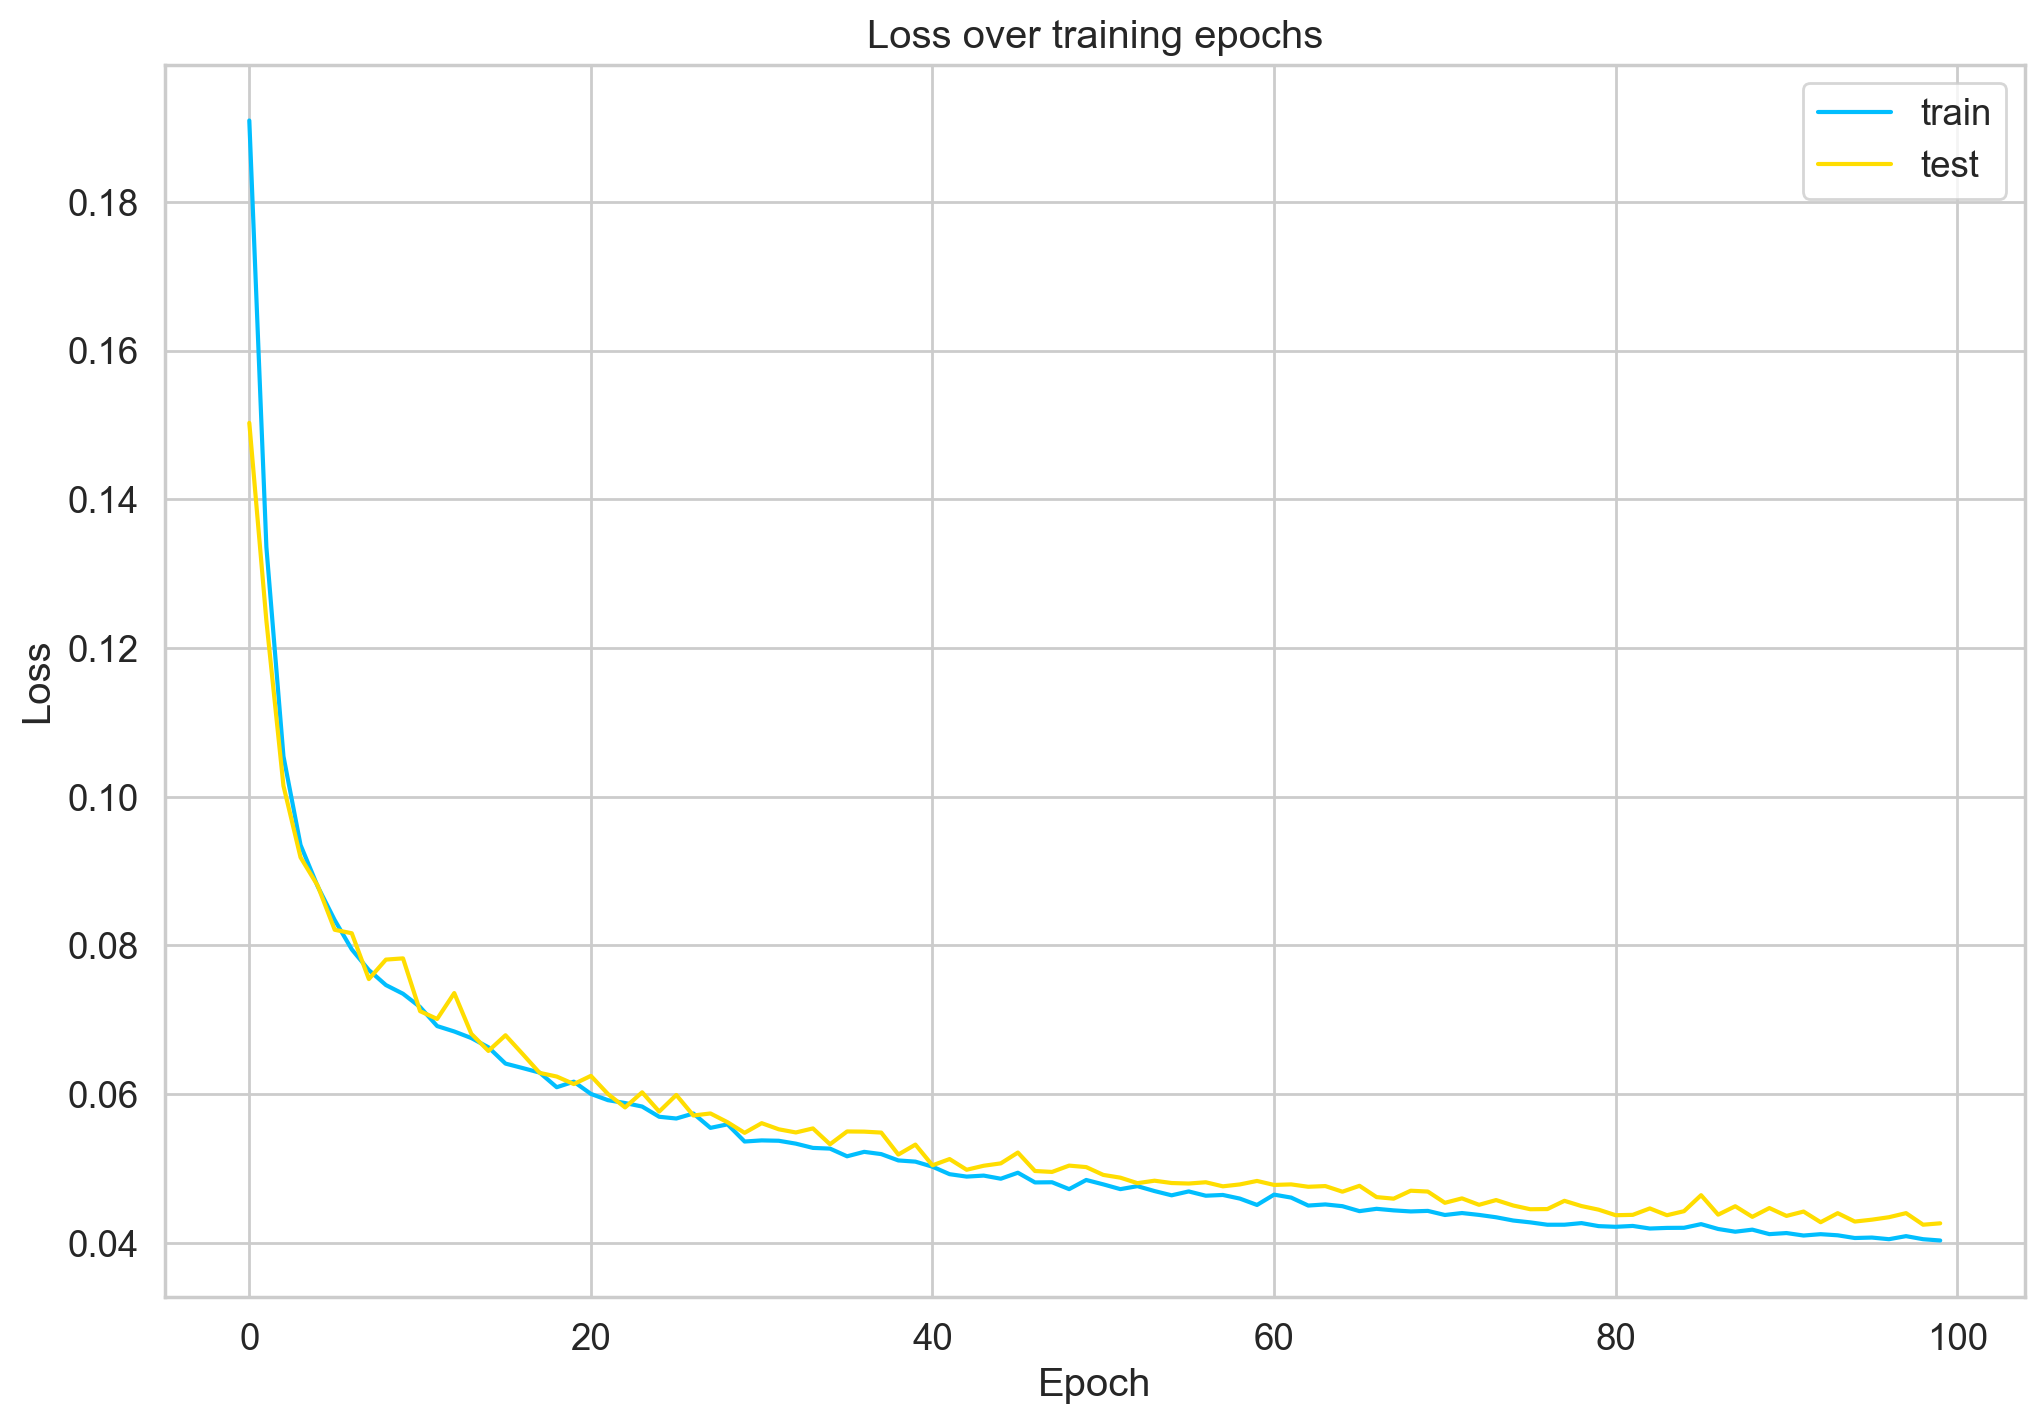

In [318]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [310]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 45/45 [01:08<00:00,  1.52s/it]


In [311]:
def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

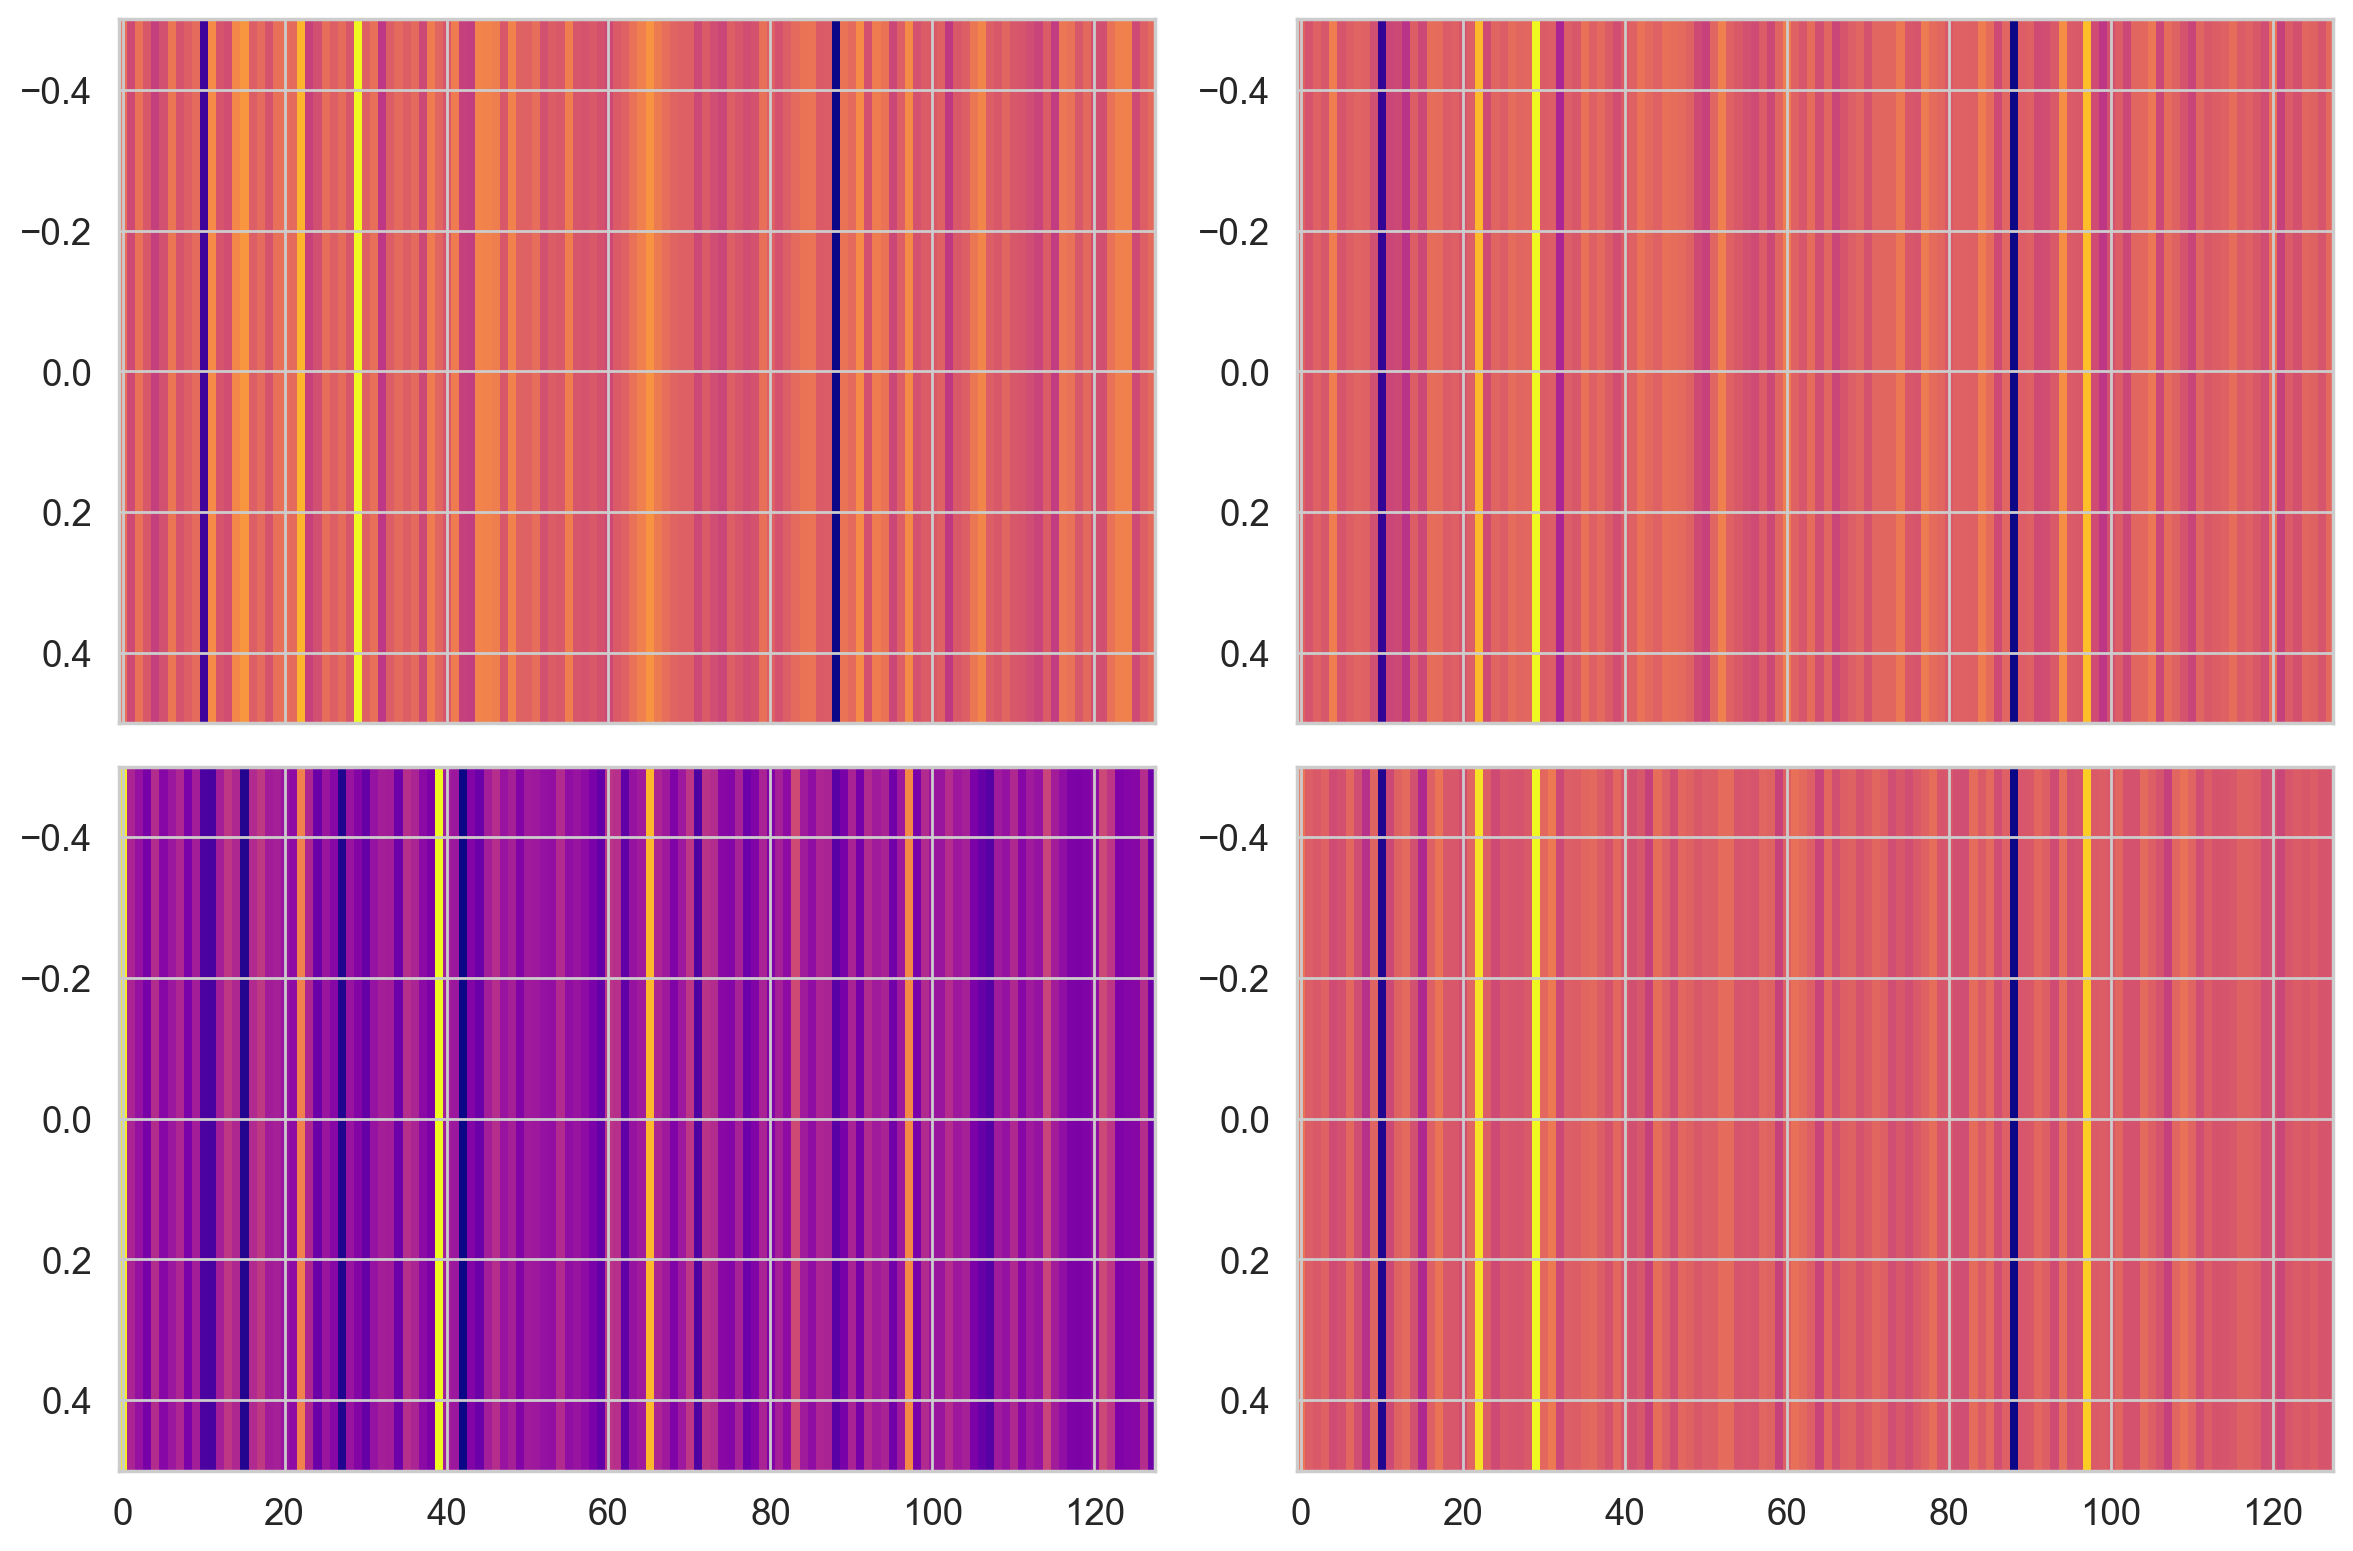

In [312]:
draw_heatmaps(embedding_list[11])

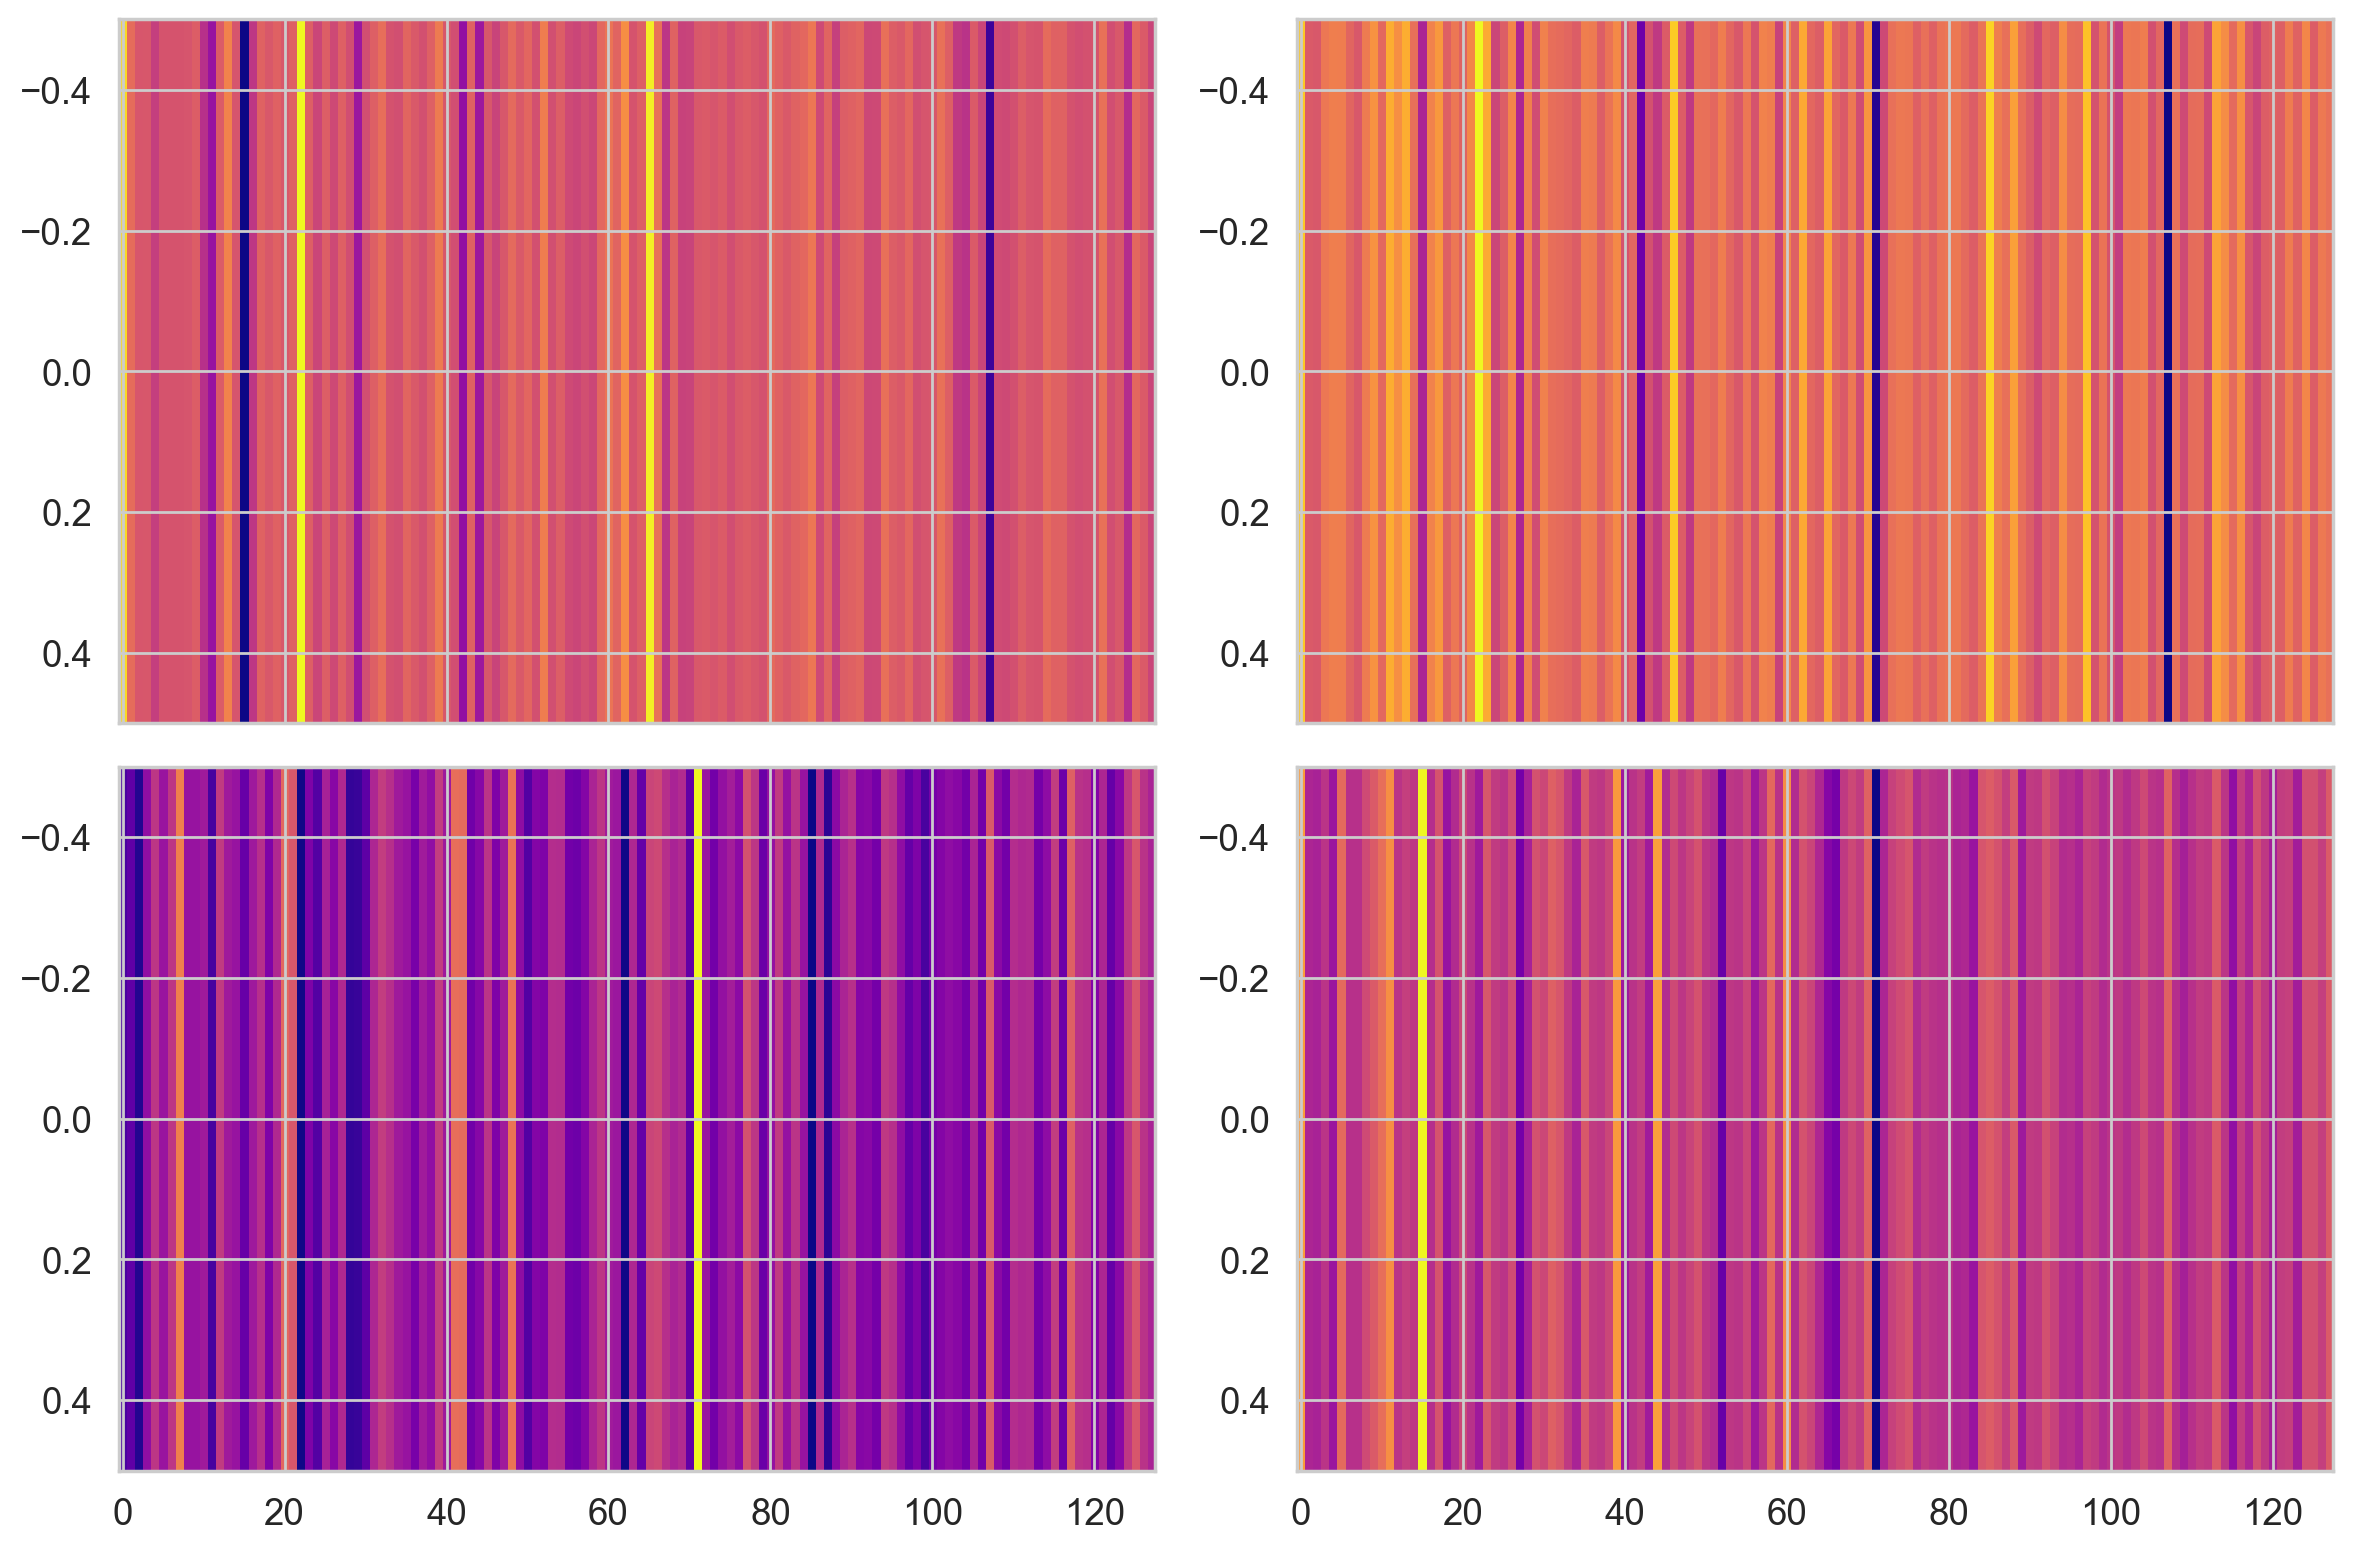

In [313]:
draw_heatmaps(embedding_list[22])

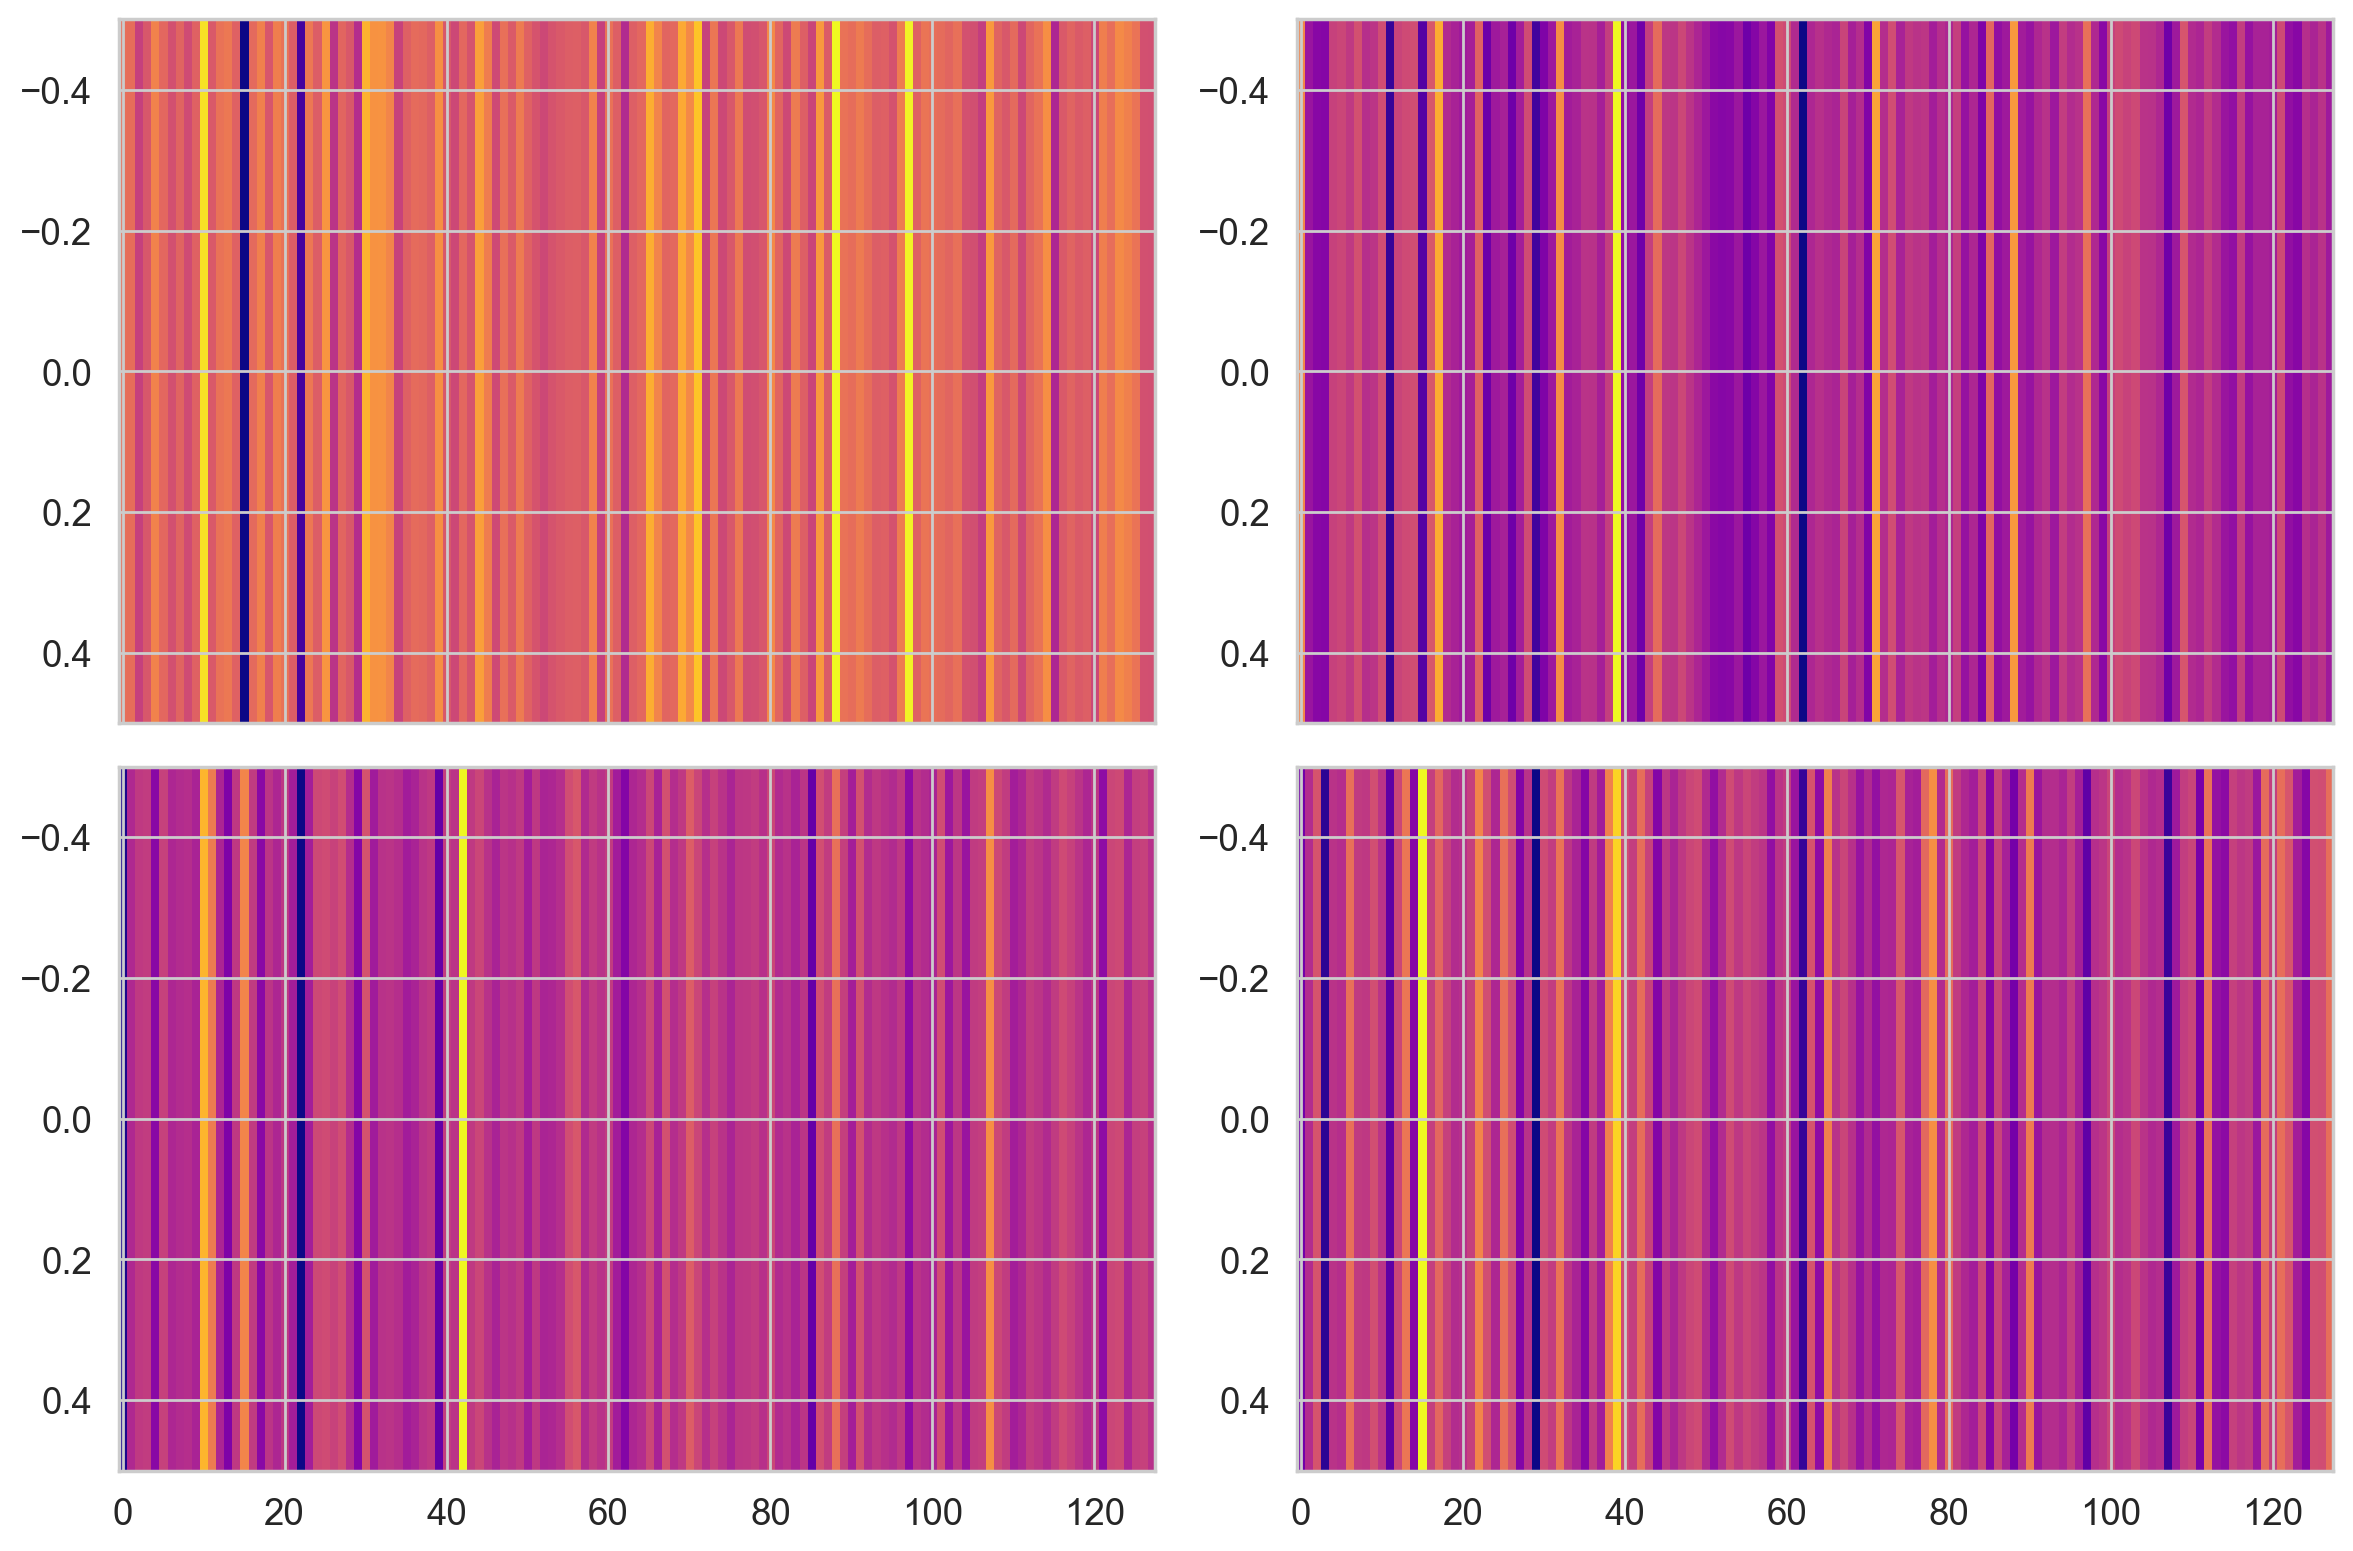

In [314]:
draw_heatmaps(embedding_list[16])

In [315]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400)

In [316]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

45it [00:04, 10.74it/s]


In [317]:
gen_video_from_embeddings(embedding_list[7][10],model,"embed_video.mp4")

IndexError: list index out of range

In [ ]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")